# Лабораторная работа 1

## Цели работы :

1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом Apache Spark и возможностями, которые он предоставляет для обработки больших данных;
3. Получить навыки выполнения разведочного анализа данных использованием pyspark

# Задачи работы

**Выполнить разведочный анализ датасета с определением:**

1. типов признаков в датасете;
2. пропущенных значений и их устранением;
3. выбросов и их устранением;
4. расчетом статистических показателей признаков (средних, квартилей и т.д.);
5. визуализацией распределения наиболее важных признаков;
6. корреляций между признаками

Датасет авиабилетов из "Expedia": https://www.kaggle.com/datasets/dilwong/flightprices

In [1]:
# Подключение к гугл диску для доступа к датасету
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
import pylab
import seaborn as sns
import scipy.stats as scipy_stats
from scipy.stats import probplot
from functools import reduce

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
!pip install PySpark
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row, DataFrame, SparkSession, SQLContext, functions, Window
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import skewness, lit, desc, col,when, size, array_contains, row_number, \
isnan, udf, hour, array_min, array_max, countDistinct, median, collect_list, \
max, mean, min, stddev, monotonically_increasing_id
from pyspark.sql.types import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PySpark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=de4386383c55b7013100f02156ecb98a06039a7034ae58aa38bc7cec49a02d90
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built PySpark


In [4]:
MAX_MEMORY = '12G'

# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Tp_Lab1") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

spark = init_spark()
filename_data = '/content/drive/MyDrive/SOBD/flight_prices2.csv'

# Load the main data set into pyspark data frame
df = spark.read.options(inferSchema='True', header='True', delimeter=',').csv(filename_data, mode='DROPMALFORMED')
print('Data frame type: ' + str(type(df)))

openjdk version "11.0.21" 2023-10-17
OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


### Типы данных каждой строки


In [5]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

In [6]:
# Первые 3 строкИ таблицы
df.limit(3).toPandas()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach
2,98d90cbc32bfbb05c2fc32897c7c1087,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650218700,2022-04-17T14:05:00.000-04:00,BOS,ATL,Delta,DL,Boeing 757-200,9000,947,coach


### 1. Типы признаков в датасете

In [7]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDeparture

,Column Name,Data type
0,legId,string
1,searchDate,date
2,flightDate,date
3,startingAirport,string
4,destinationAirport,string
5,fareBasisCode,string
6,travelDuration,string
7,elapsedDays,int
8,isBasicEconomy,boolean
9,isRefundable,boolean


In [8]:
# Проверка количества уникальных записей в столбцах
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
| legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+-

In [9]:
df.drop("isRefundable")

DataFrame[legId: string, searchDate: date, flightDate: date, startingAirport: string, destinationAirport: string, fareBasisCode: string, travelDuration: string, elapsedDays: int, isBasicEconomy: boolean, isNonStop: boolean, baseFare: double, totalFare: double, seatsRemaining: int, totalTravelDistance: int, segmentsDepartureTimeEpochSeconds: string, segmentsDepartureTimeRaw: string, segmentsArrivalTimeEpochSeconds: string, segmentsArrivalTimeRaw: string, segmentsArrivalAirportCode: string, segmentsDepartureAirportCode: string, segmentsAirlineName: string, segmentsAirlineCode: string, segmentsEquipmentDescription: string, segmentsDurationInSeconds: string, segmentsDistance: string, segmentsCabinCode: string]

In [10]:
print('Data frame describe (string and numeric columns only):')
print(f'Total rows: {df.count()}')
df.describe().toPandas()

Data frame describe (string and numeric columns only):
Total rows: 351192


,summary,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,baseFare,totalFare,seatsRemaining,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,count,351192,351192,351192,351192,351192,351192,351192,351192,351192,...,351192,351192,351192,351192,351192,351192,344890,351192,351192,351192
1,mean,Infinity,None,None,None,None,0.15840622793229914,238.701455329288,282.2487912600529,6.52962766805622,...,1.6672200680855312E9,None,None,None,None,None,None,10789.454267755389,1071.9529527780205,None
2,stddev,NaN,None,None,None,None,0.36526234792375173,172.2567871878333,185.15793324307208,2.668478900881479,...,587488.0664324418,None,None,None,None,None,None,5093.919963115669,719.6213011872595,None
3,min,00001a7fb6213a9050cd5c90622fd599,ATL,ATL,B0,P1D,0,0.41,24.59,0,...,1650200400,2022-04-17T09:00:00.000-04:00,ABQ||ATL,ATL,Alaska Airlines,4B||4B||AA,AIRBUS INDUSTRIE A320 SHARKLETS,10020,1003||1110,business
4,max,ffff6d5ee08839437d54ca3dbafab5de,SFO,SFO,ZVBJZNN3,PT9H9M,2,7344.19,7918.6,10,...,1668336840||1668361380,2022-11-13T05:54:00.000-05:00||2022-11-13T12:4...,XNA||ORD,TTN||RSW,United||United||United||United,UA||UA||UA||UA,||||Embraer 175 (Enhanced Winglets),9960||9900,None||None||None,premium coach||coach||coach||coach


### 2. Обнаружение пропущенных значений и аномальных нулей

In [11]:
# Определение списков столбцов на основе их типов данных
string_columns = [
    'legId', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration',
    'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds',
    'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
    'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
    'segmentsDistance', 'segmentsCabinCode'
]

numeric_with_zeroes_columns = ['elapsedDays', 'seatsRemaining']
numeric_without_zeroes_columns = ['baseFare', 'totalFare', 'totalTravelDistance']

boolean_columns = ['isBasicEconomy', 'isNonStop']

date_columns = ['searchDate', 'flightDate']

# Инициализация словаря для хранения количества пропущенных значений для каждого столбца
missing_values = {}

# Итерация по столбцам DataFrame и подсчет пропущенных значений для каждого типа
for index, column in enumerate(df.columns):
    if column in string_columns: # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_with_zeroes_columns: # check None, NaN and Null
        missing_count = df.filter(col(column) == None | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_without_zeroes_columns:  # check zeroes, None, NaN and Null
        missing_count = df.filter(col(column).isin([0,None]) | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in boolean_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in date_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})

# Создание DataFrame из словаря missing_values
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

# Определение столбцов с пропущенными значениями
columns_with_missing_values = []
for column in missing_df:
    if missing_df[column].values[0] != 0:
        columns_with_missing_values.append(column)

# Вывод информации о пропущенных значениях
missing_df[columns_with_missing_values]
print(missing_values)

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isNonStop,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6302,0,0,0


,totalTravelDistance,segmentsEquipmentDescription
0,34941,6302


{'legId': 0, 'searchDate': 0, 'flightDate': 0, 'startingAirport': 0, 'destinationAirport': 0, 'fareBasisCode': 0, 'travelDuration': 0, 'elapsedDays': 0, 'isBasicEconomy': 0, 'isNonStop': 0, 'baseFare': 0, 'totalFare': 0, 'seatsRemaining': 0, 'totalTravelDistance': 34941, 'segmentsDepartureTimeEpochSeconds': 0, 'segmentsDepartureTimeRaw': 0, 'segmentsArrivalTimeEpochSeconds': 0, 'segmentsArrivalTimeRaw': 0, 'segmentsArrivalAirportCode': 0, 'segmentsDepartureAirportCode': 0, 'segmentsAirlineName': 0, 'segmentsAirlineCode': 0, 'segmentsEquipmentDescription': 6302, 'segmentsDurationInSeconds': 0, 'segmentsDistance': 0, 'segmentsCabinCode': 0}


In [12]:
print(f'Number of rows before deleting na values: {df.count()}')
df = df.na.drop(subset=columns_with_missing_values)
print(f'Number of rows after deleting na values: {df.count()}')

Number of rows before deleting na values: 351192
Number of rows after deleting na values: 311206


### 3. Определение выбросов и удаление выбросов

In [13]:
# Количество строк после удаления
df.count()

311206

In [14]:
# Создаем новый DataFrame 'cleaned_dataframe', в котором удаляются все строки с пропущенными значениями
cleaned_dataframe = df.dropna()

# Выводим количество строк в 'cleaned_dataframe' после удаления пропущенных значений
# (этот блок дублирует предыдущий, но так как в прошлой итерации лабы dropna у меня не удалял пустые строки, то решил вот так подстраховаться)
cleaned_dataframe.count()

311206

In [15]:
from pyspark.sql import functions as F

selected_columns = ['baseFare', 'totalFare', 'totalTravelDistance']

# Фильтрация выбросов для каждого столбца
for column in selected_columns:
    # Рассчет квартилей
    quartiles = cleaned_dataframe.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    # Рассчет межквартильного размаха
    IQR = quartiles[1] - quartiles[0]

    # Определение границ выбросов как первый квартиль - 1.5 * межквартильный размах
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR

    # Фильтрация данных и подсчет выбросов после фильтрации
    # Подсчитываются значения, находящиеся ниже и выше границ межквартильного размаха после фильтрации
    below_quartile_count_before = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_before = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (до)'{column}': Снизу выбросов - {below_quartile_count_before}, Сверху выбросов - {above_quartile_count_before}")

    # Рассчет максимального и минимального значения до фильтрации
    max_value_before = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_before = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы до фильтрации
    median_value_before = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (до) '{column}': Максимальное значение - {max_value_before}, Минимальное значение - {min_value_before}, Медиана - {median_value_before}")

    # Фильтрация данных
    cleaned_dataframe = cleaned_dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    # Фильтрация данных и подсчет выбросов после фильтрации
    below_quartile_count_after = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_after = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (после)'{column}': Снизу выбросов - {below_quartile_count_after}, Сверху выбросов - {above_quartile_count_after}")

    # Рассчет максимального и минимального значения после фильтрации
    max_value_after = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_after = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы после фильтрации
    median_value_after = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (после) '{column}': Максимальное значение - {max_value_after}, Минимальное значение - {min_value_after}, Медиана - {median_value_after}")

Столбец (до)'baseFare': Снизу выбросов - 0, Сверху выбросов - 4783
Столбец (до) 'baseFare': Максимальное значение - 7344.19, Минимальное значение - 13.37, Медиана - 206.87
Столбец (после)'baseFare': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'baseFare': Максимальное значение - 682.79, Минимальное значение - 13.37, Медиана - 202.79
Столбец (до)'totalFare': Снизу выбросов - 0, Сверху выбросов - 703
Столбец (до) 'totalFare': Максимальное значение - 771.3, Минимальное значение - 28.97, Медиана - 238.6
Столбец (после)'totalFare': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'totalFare': Максимальное значение - 735.71, Минимальное значение - 28.97, Медиана - 238.6
Столбец (до)'totalTravelDistance': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (до) 'totalTravelDistance': Максимальное значение - 4421, Минимальное значение - 89, Медиана - 1517.0
Столбец (после)'totalTravelDistance': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'totalTravelDistance': Максима

### 4. Расчет статистических показателей признаков

In [17]:
statistics_summary = cleaned_dataframe.describe()
statistics_summary.toPandas()

,summary,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,baseFare,totalFare,seatsRemaining,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,count,305720,305720,305720,305720,305720,305720,305720,305720,305720,...,305720,305720,305720,305720,305720,305720,305720,305720,305720,305720
1,mean,Infinity,None,None,None,None,0.1452832657333508,238.62285032056624,279.2923175132959,6.959181604082167,...,1.6672168182852564E9,None,None,None,None,None,None,10558.725961538461,1041.0558760683762,None
2,stddev,NaN,None,None,None,None,0.3523867826809697,138.72446019414505,151.44137993708136,2.1560235108981853,...,588043.1235004393,None,None,None,None,None,None,4988.4833555775795,702.2108540347957,None
3,min,00001a7fb6213a9050cd5c90622fd599,ATL,ATL,B0,P1D,0,13.37,28.97,0,...,1650200400,2022-04-17T09:00:00.000-04:00,ABQ||ATL,ATL,Alaska Airlines,4B||4B||AA,AIRBUS INDUSTRIE A321 SHARKLETS,10020,1003||1110,coach
4,max,ffff6d5ee08839437d54ca3dbafab5de,SFO,SFO,ZVBJZNN3,PT9H9M,1,662.34,735.71,10,...,1668336840||1668361380,2022-11-13T05:54:00.000-05:00||2022-11-13T12:4...,XNA||ORD,TTN||RSW,United||United||United||United,UA||UA||UA||UA,||||Embraer 175 (Enhanced Winglets),9960||9900,99||59||672,premium coach||coach||coach


In [19]:
# Минимум, максимум и среднеее
def calculate_min_mean_max_statistic_indicators(df, column):
    min_value = df.agg(min(column).alias(f'min_{column}')).collect()[0][f'min_{column}']
    mean_value = df.agg(mean(column).alias(f'mean_{column}')).collect()[0][f'mean_{column}']
    max_value = df.agg(max(column).alias(f'max_{column}')).collect()[0][f'max_{column}']
    return (min_value, mean_value, max_value)

# Среднеквадратическое отклонение
def calculate_stdev(df, column):
    stddev_value = df.agg(stddev(column).alias(f'stddev_{column}')).collect()[0][f'stddev_{column}']
    return stddev_value

# Квартили
def calculate_quartiles(df, column):
    q1, median, q3 = df.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
    return q1, median, q3

# Вывод
def calculate_statistical_indicators(df, column):
    min_value, mean_value, max_value =calculate_min_mean_max_statistic_indicators(df, column)
    stddev_value = calculate_stdev(df, column)
    q1, median, q3 = calculate_quartiles(df, column)
    return  (min_value, mean_value, max_value, stddev_value, q1, median, q3)
statistical_indicators = {}

for col in numeric_with_zeroes_columns:
    statistical_indicators[col] = calculate_statistical_indicators(cleaned_dataframe, col)

for col in numeric_without_zeroes_columns:
    statistical_indicators[col] = calculate_statistical_indicators(cleaned_dataframe, col)

for key, value in statistical_indicators.items():
    print(f"""
        Column: {key}
          -- Min: {value[0]}
          -- Mean: {value[1]}
          -- Max: {value[2]}
          -- Stddev: {value[3]}
          -- q1: {value[4]}
          -- q2(median): {value[5]}
          -- q3: {value[6]}
        """)


        Column: elapsedDays
          -- Min: 0
          -- Mean: 0.1452832657333508
          -- Max: 1
          -- Stddev: 0.3523867826809697
          -- q1: 0.0
          -- q2(median): 0.0
          -- q3: 0.0
        

        Column: seatsRemaining
          -- Min: 0
          -- Mean: 6.959181604082167
          -- Max: 10
          -- Stddev: 2.1560235108981853
          -- q1: 7.0
          -- q2(median): 7.0
          -- q3: 9.0
        

        Column: baseFare
          -- Min: 13.37
          -- Mean: 238.62285032056624
          -- Max: 662.34
          -- Stddev: 138.72446019414505
          -- q1: 124.65
          -- q2(median): 200.0
          -- q3: 336.74
        

        Column: totalFare
          -- Min: 28.97
          -- Mean: 279.2923175132959
          -- Max: 735.71
          -- Stddev: 151.44137993708136
          -- q1: 156.6
          -- q2(median): 238.6
          -- q3: 382.21
        

        Column: totalTravelDistance
          -- Min: 89
    

### 5. Визуализация распределения наиболее важных признаков

In [27]:
def plot_histogram(df, column, bins='auto', figsize=(10, 6)):
    data = df.select(column).rdd.flatMap(lambda x: x).collect()

    plt.figure(figsize=figsize)
    plt.hist(data, bins=bins, color='blue')

    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

Column: elapsedDays


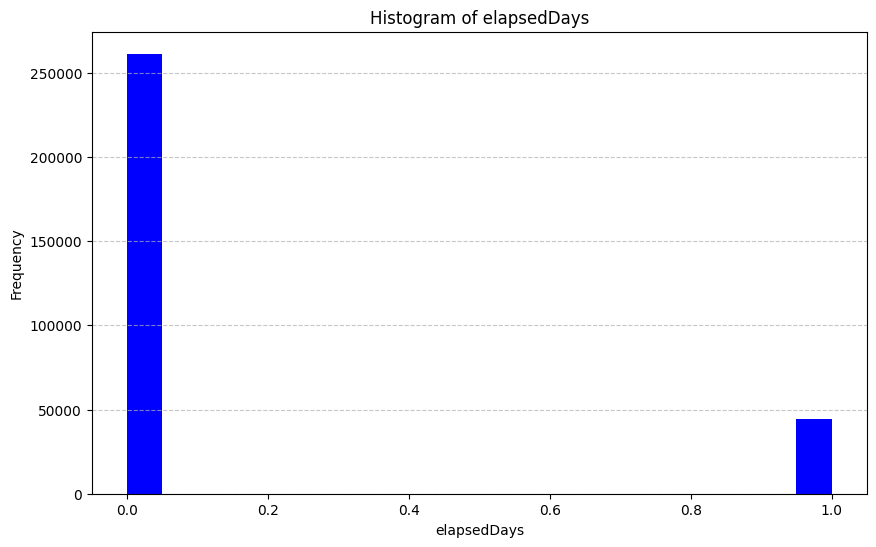

Column: seatsRemaining


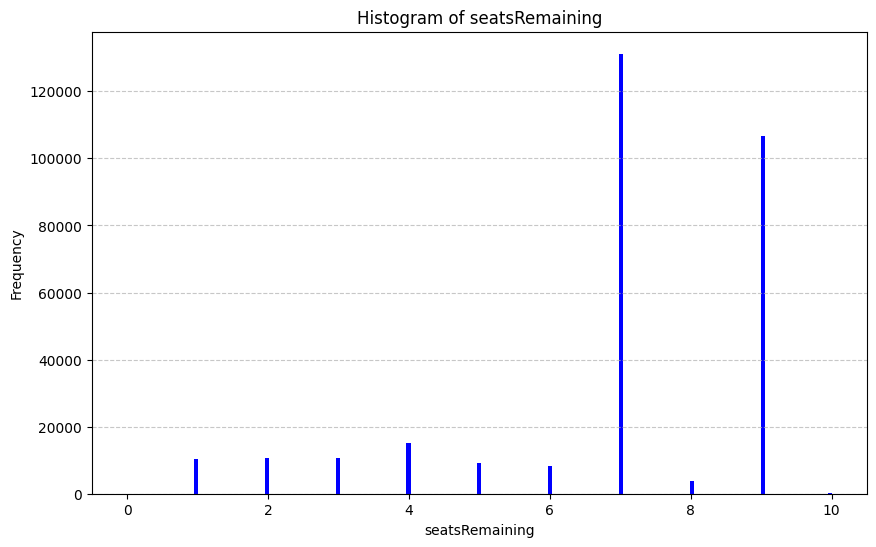

Column: baseFare


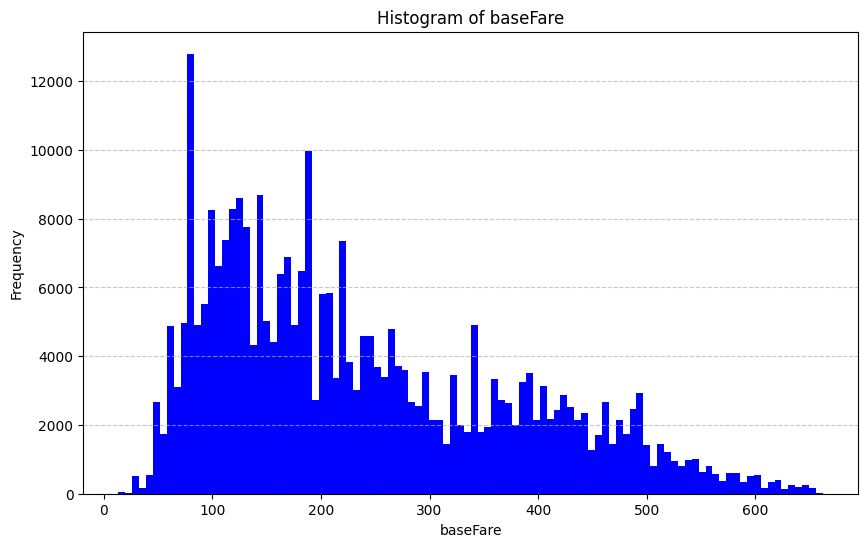

Column: totalFare


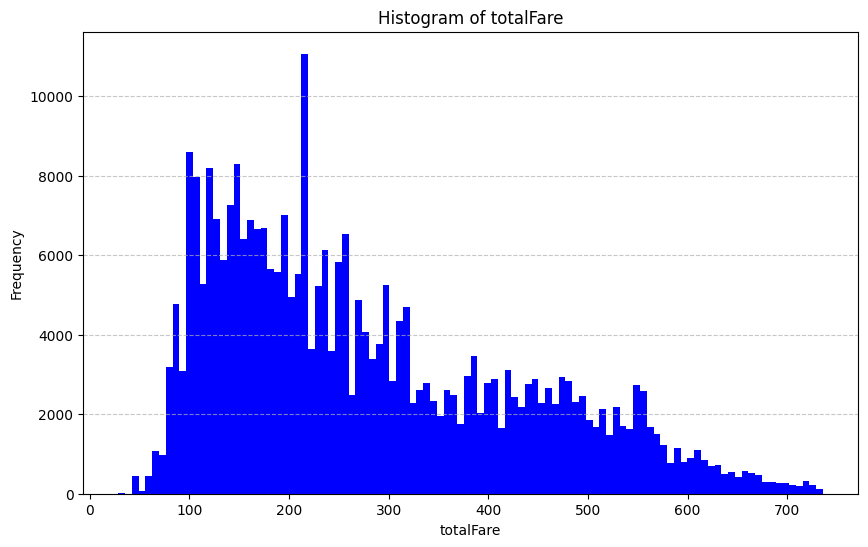

Column: totalTravelDistance


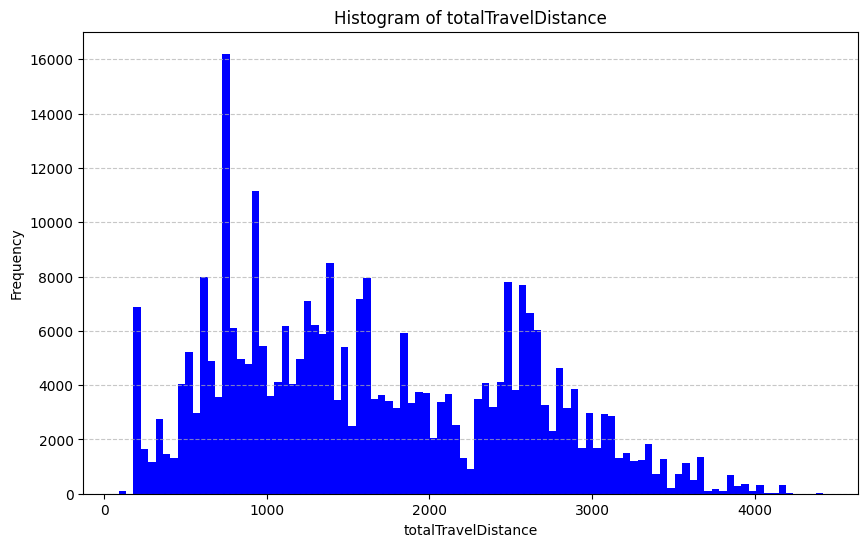

In [28]:
for column in numeric_with_zeroes_columns:
    print(f'Column: {column}')
    plot_histogram(cleaned_dataframe, column)

for column in numeric_without_zeroes_columns:
    print(f'Column: {column}')
    plot_histogram(cleaned_dataframe, column)

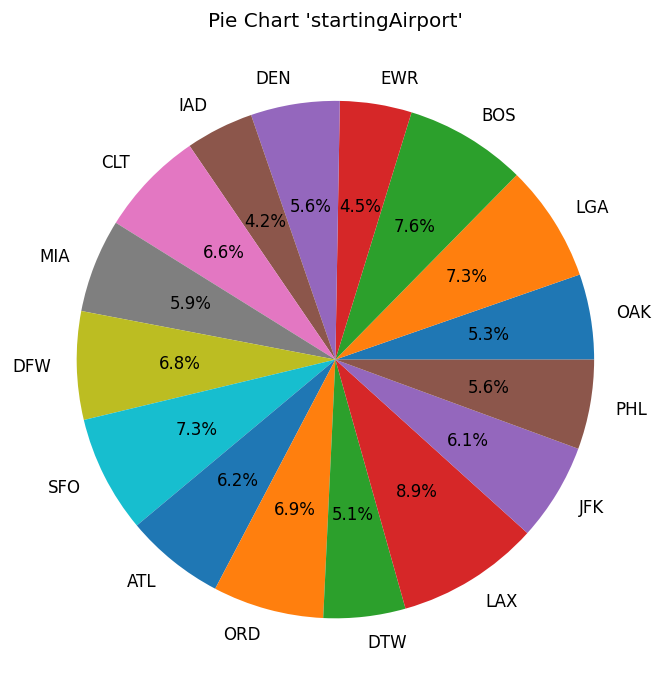

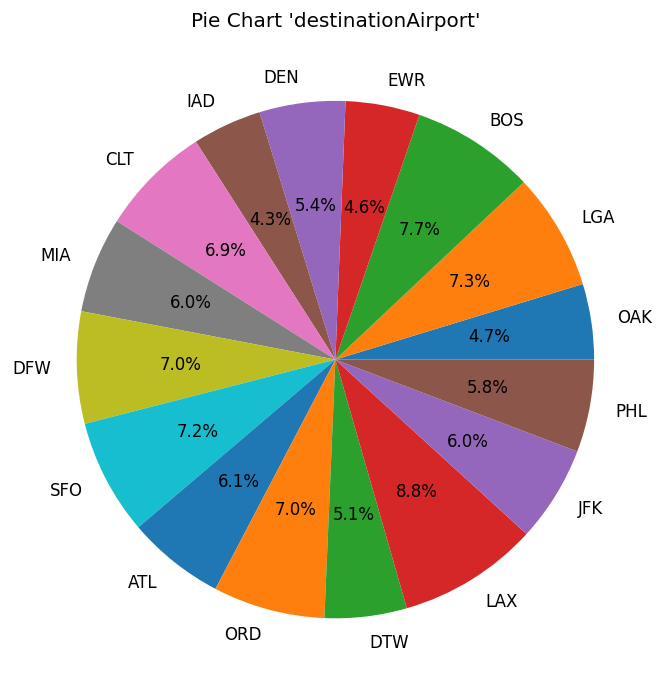

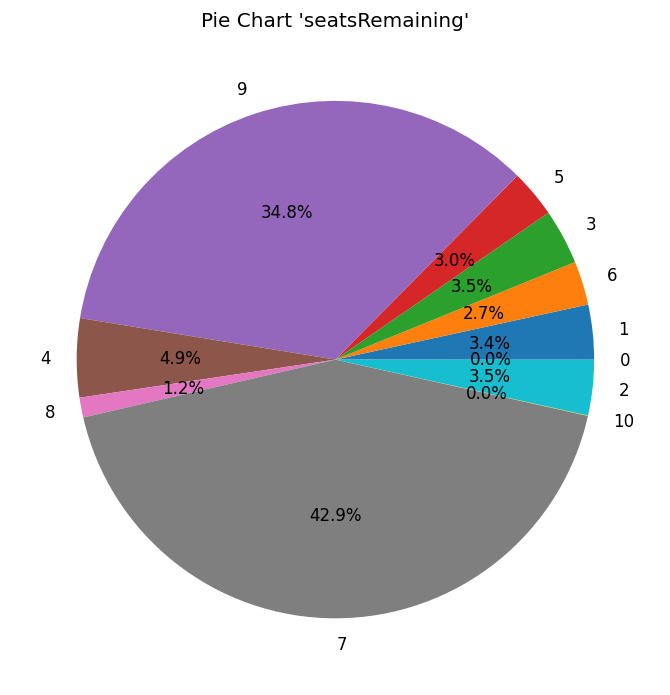

In [29]:
def pie_chart(df, column):

    pandas_df = df.groupby(column).count().toPandas()
    pandas_df = pandas_df.set_index(pandas_df.columns[0])
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect='equal'), dpi=120)

    data = pandas_df['count']
    categories = pandas_df.index

    plt.pie(data, labels = categories, autopct="%1.1f%%")
    ax.set_title(f"Pie Chart '{column}'")
    plt.show()

pie_chart(cleaned_dataframe, 'startingAirport')
pie_chart(cleaned_dataframe, 'destinationAirport')
pie_chart(cleaned_dataframe, 'seatsRemaining')


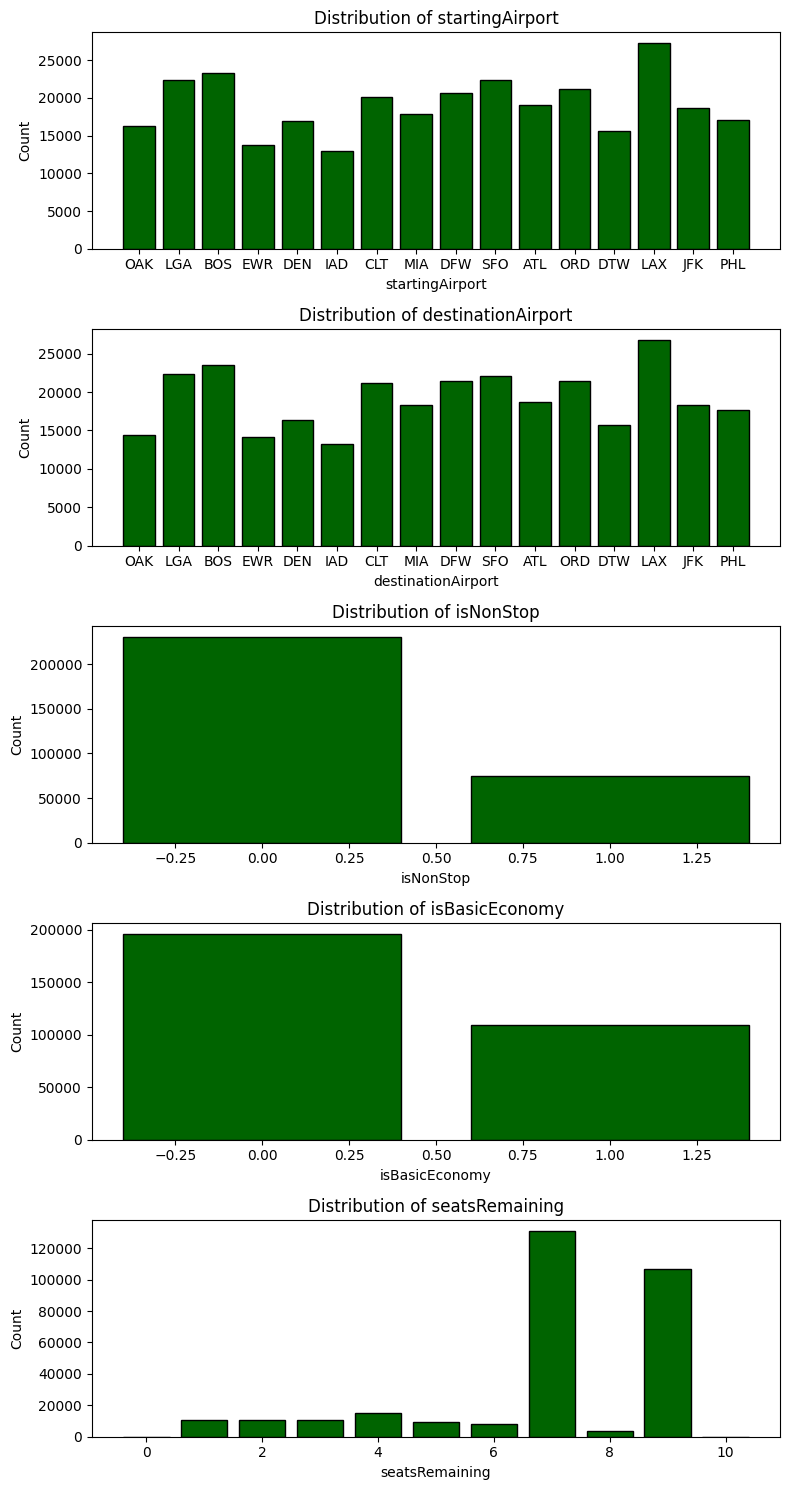

In [30]:
# Определение списка признаков для построения гистограмм для категориальных и бинарных признаков
selected_features = ['startingAirport', 'destinationAirport', 'isNonStop',
                    'isBasicEconomy',
                    'seatsRemaining']

# Создание фигуры и массива подграфиков
fig, axs = plt.subplots(len(selected_features), 1, figsize=(8, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Сгруппировать по признаку и подсчитать количество
    data_grouped = cleaned_dataframe.groupBy(feature).count().collect()
    # Извлечение данных для построения графика
    categories = [row[0] for row in data_grouped]
    counts = [row[1] for row in data_grouped]
    # Построение гистограммы для текущего признака на соответствующем подграфике
    axs[i].bar(categories, counts, color='darkgreen', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')

# Регулировка расположения подграфиков
plt.tight_layout();

# Отображение графика
plt.show();

### 6. Корреляции между признаками
Создание корреляционной матрицы - таблицы, которая показывает степень линейной зависимости между парами числовых переменных.



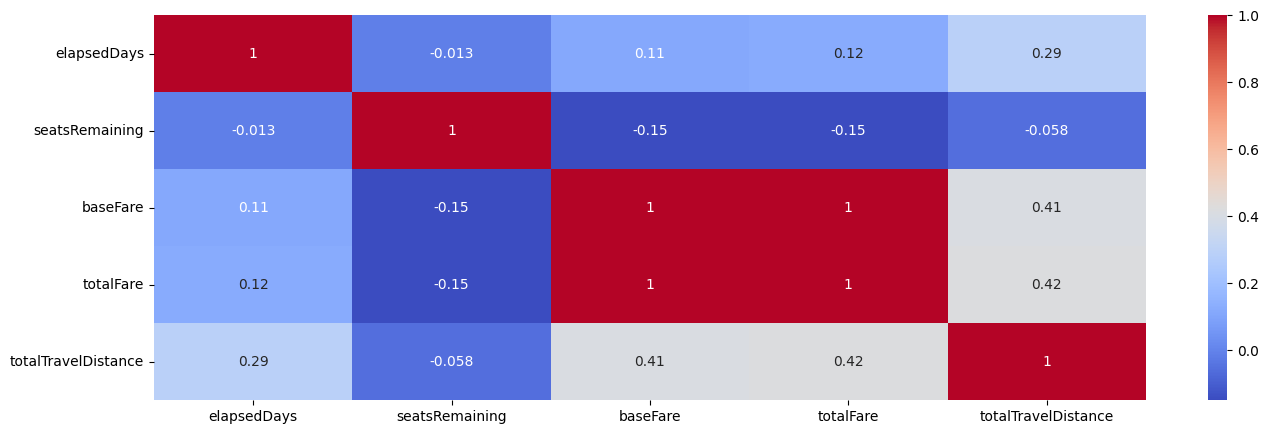

In [31]:
# Определение имени столбца для векторизованных признаков
vector_col = 'corr_features'
# Сбор всех числовых столбцов (с учетом столбцов с и без нулей)
all_columns = numeric_with_zeroes_columns + numeric_without_zeroes_columns

# Использование VectorAssembler для создания векторизованного столбца
assembler = VectorAssembler(inputCols=all_columns, outputCol=vector_col)
df_vector = assembler.transform(cleaned_dataframe).select(vector_col)

# Расчет корреляционной матрицы
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()
# Создание DataFrame из корреляционной матрицы
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=all_columns, index=all_columns)

plt.figure(figsize=(16,5));
sns.heatmap(
    corr_matrix_df,
    xticklabels=corr_matrix_df.columns.values,
    yticklabels=corr_matrix_df.columns.values,
    cmap= 'coolwarm',
    annot=True
);

Как видно из корреляционной матрицы:
- `baseFare` и `totalFare` имеют сильную положительную корреляцию, поскольку, очевидно, что на одну и ту же цену билета всегда будет одна и та же сумма налогов;
- `baseFare`, `totalFare` и `totalTravelDistance` имеют среднюю положительную корреляцию, так как цена билета в основном зависит от общего пройденного расстояния;
- линейная корреляция между остальными столбцами практически отсутствует, так как близка к нулю.

### Вывод
В ходе лабораторной работы был проведен разведочный анализ данных с помощью PySpark: определены типы признаков в датасете, устранены пропущенные значения и выбросы, рассчитаны статистические показатели признаков, визуализированы распределение наиболее важных признаков и корреляция между ними.

# Лабораторная работа 2

## Цели работы :

1. Познакомиться с базовыми алгоритмами машинного обучения;
2. Познакомиться с реализацией машинного обучения в библиотеке Spark ML;
3. Получить навыки разработки программного обеспечения для анализа данных с
использованием` pyspark`.

### Постановка задачи
Выполнить анализ датасета с помощью двух алгоритмов машинного обучения в соответствии с индивидуальным вариантомм:
|Индивидуальный вариант|Задача регрессии|Задача бинарной классификации|
|:--------------------:|:--------------:|:---------------------------:|
|          2           |LinearRegression|   GradientBoostingMachine   |



Вариант №2: "Датасет авиабилетов из Expedia".

Источник: https://www.kaggle.com/datasets/dilwong/flightprices

In [36]:
# Цель - предсказать 'label' на основе входных признаков
data = cleaned_dataframe.select(
    'startingAirport',
    'destinationAirport',
    'elapsedDays',
    col('isBasicEconomy').cast('Int').alias('isBasicEconomy'),
    col('isNonStop').cast('Int').alias('isNonStop'),
    'baseFare',
    'totalFare',
    col('totalTravelDistance').alias('label')
)
data.show(10)

+---------------+------------------+-----------+--------------+---------+--------+---------+-----+
|startingAirport|destinationAirport|elapsedDays|isBasicEconomy|isNonStop|baseFare|totalFare|label|
+---------------+------------------+-----------+--------------+---------+--------+---------+-----+
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|        0|  213.02|    251.1|  956|
|            ATL|               BOS|          0|             0|        0|  213.02|    251.1|  956|
|         

### Линейная регрессия

Процесс построения модели линейной регрессии в PySpark обычно включает в себя следующие шаги:

1. Подготовка данных: Загрузка данных и предварительная обработка, например, преобразование категориальных признаков и масштабирование числовых.

2. Создание столбца признаков: Объединение всех признаков в один вектор.

3. Обучение модели: Создание экземпляра LinearRegression, создание Pipeline с этой моделью и обучение модели на тренировочных данных.

4. Оценка модели: Использование тестовых данных для оценки качества предсказаний модели.

In [37]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer, MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
# Кодирует  столбец строковых меток в столбец индексов меток.
# применяется для преобразования категориальных переменных в числовой форма
strIdx = StringIndexer(inputCols = ['startingAirport', 'destinationAirport'], outputCols = ['startingAirportIdx', 'destinationAirportIdx'])
# Отображает столбец индексов категорий в столбец бинарных векторов,
# где только одна единица указывает на присутствие конкретной категории
oneHotEnc = OneHotEncoder(inputCols=['startingAirportIdx', 'destinationAirportIdx'], outputCols=['startingAirportEnc', 'destinationAirportEnc'])
# Отображает заданный список столбцов в один векторный столбец
catVect = VectorAssembler(inputCols = ['startingAirportEnc', 'destinationAirportEnc', 'isBasicEconomy', 'isNonStop'], outputCol='catFeatures')
# Объединяет числовые признаки в один вектор
numVect = VectorAssembler(inputCols = ['baseFare', 'totalFare', 'elapsedDays'], outputCol='numFeatures')
# Работает с вектором признаков
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol='normFeatures')
# Объединяет категориальные признаки (catFeatures) и нормализованные числовые признаки (normFeatures) в один вектор признаков
featVect = VectorAssembler(inputCols=['catFeatures', 'normFeatures'], outputCol='features')
# одгоняет линейную регрессионную модель к входным данным
lr = LinearRegression(labelCol='label', featuresCol='features')

pipeline = Pipeline(stages=[strIdx, oneHotEnc, catVect, numVect, minMax, featVect, lr])

### Настройка параметров регрессии

In [38]:
# Разделим данные на обучающую и тестовую выборки
splits = data.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1].withColumnRenamed('label', 'trueLabel')

# Создаем сетку гиперпараметров
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.3, 0.5]) \
    .addGrid(lr.maxIter, [50, 100, 150]).build()

# Создаем кросс-валидатор
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)
model = crossval.fit(train)

1. Исходные данные data разделяются на обучающую (train) и тестовую (test) выборки в соотношении 80% к 20%. train содержит 80% данных, а test - 20%.
2. Создается сетка гиперпараметров для модели логистической регрессии (lr).
3. Гиперпараметры включают regParam (параметр регуляризации) и maxIter (максимальное количество итераций обучения).
4. Рассматриваются различные комбинации значений для каждого параметра.

### Генерация предсказаний модели регрессии

In [39]:
predictions = model.transform(test)
predictions = predictions.select('features', 'prediction', 'trueLabel')
predictions.show(100, truncate=False)

+--------------------------------------------------------------------------+------------------+---------+
|features                                                                  |prediction        |trueLabel|
+--------------------------------------------------------------------------+------------------+---------+
|(35,[7,16,32,33],[1.0,1.0,0.09265451407615144,0.10419673430115743])       |1007.7123357648087|947      |
|(35,[7,16,32,33],[1.0,1.0,0.09265451407615144,0.10419673430115743])       |1007.7123357648087|947      |
|(35,[7,16,32,33],[1.0,1.0,0.09265451407615144,0.10419673430115743])       |1007.7123357648087|947      |
|(35,[7,16,32,33],[1.0,1.0,0.09265451407615144,0.10419673430115743])       |1007.7123357648087|947      |
|(35,[7,16,32,33],[1.0,1.0,0.09265451407615144,0.10419673430115743])       |1007.7123357648087|947      |
|(35,[7,16,32,33],[1.0,1.0,0.09265451407615144,0.11212044033166368])       |1052.2161273310085|947      |
|(35,[7,16,32,33],[1.0,1.0,0.09265451407615144

### Оценим качество модели

In [40]:
 evaluator_mse = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="mse")
 mse = evaluator_mse.evaluate(predictions)
 print(f'Metric "MSE" on test data: {mse:.3f}')

 evaluator_mae = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="mae")
 mae = evaluator_mae.evaluate(predictions)
 print(f'Metric "mae" on test data: {mae:.3f}')

 evaluator_rmse = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="rmse")
 rmse = evaluator_rmse.evaluate(predictions)
 print(f'Metric "rmse" on test data: {rmse:.3f}')

 evaluator_r2 = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="r2")
 r2 = evaluator_r2.evaluate(predictions)
 print(f'Metric "R^2" on test data: {r2:.3f}')

Metric "MSE" on test data: 318405.234
Metric "mae" on test data: 421.577
Metric "rmse" on test data: 564.274
Metric "R^2" on test data: 0.600


**Root Mean Squared Error (RMSE)** на тестовых данных составляет 564.759.
RMSE измеряет среднеквадратичное отклонение предсказанных значений от фактических значений.
Чем ближе значение RMSE к нулю, тем лучше. 564.759 может считаться высоким значением,
и это может свидетельствовать о том, что модель не всегда точно предсказывает целевую переменную.

**Mean Absolute Error (MAE)** на тестовых данных равен 421.139. MAE измеряет среднее абсолютное отклонение предсказанных значений от фактических значений. Как и RMSE, MAE чувствителен к большим отклонениям. Значение 421.139 может служить показателем того, насколько в среднем модель ошибается в предсказании целевой переменной.

**R-squared (R^2** на тестовых данных равен 0.597. R^2 представляет собой коэффициент детерминации и измеряет долю дисперсии зависимой переменной, объясненную моделью. Значение R^2 от 0 до 1, и чем ближе к 1, тем лучше модель объясняет изменение в зависимой переменной. Значение 0.597 говорит о том, что модель объясняет примерно 59.7% дисперсии в данных, что может быть считаться умеренно хорошим результатом.

**MSE (Mean Squared Error)** - это метрика, используемая для оценки качества модели, обученной на регрессии. Эта метрика измеряет среднеквадратичную разность между фактическими и предсказанными значениями: 318952.264.

In [41]:
# Вывод лучших параметров
best_model = model.bestModel
best_parameters = best_model.stages[-1].extractParamMap()
print("Лучшие параметры модели LinearRegression:")
for param, value in best_parameters.items():
    print(f"{param.name}: {value}")

Лучшие параметры модели LinearRegression:
aggregationDepth: 2
elasticNetParam: 0.0
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: label
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 50
predictionCol: prediction
regParam: 0.0
solver: auto
standardization: True
tol: 1e-06


1. aggregationDepth: 2: процесс обучения использует двухуровневую агрегацию.Значение 2 может указывать на то, что используется умеренная сложность
2. elasticNetParam: 0.0: модели используется только L2-регуляризация.
3. epsilon: 1.35: : Параметр регуляризации, который добавляется к функции потерь во время обучения модели.  Значение 1.35 может быть оптимальным для заданной задачи и данных.
4. featuresCol: features: Имя столбца, содержащего признаки."
5. fitIntercept: True: Указывает, что модель должна оценить коэффициент пересечения (intercept).
6. labelCol: label: Имя столбца, содержащего целевую переменную.
7. loss: squaredError: Функция потерь, используемая в модели, является среднеквадратичной ошибкой.
8. maxBlockSizeInMB: 0.0: Это параметр, влияющий на производительность обучения.
9. maxIter: 50: Максимальное количество итераций.,
10. predictionCol: prediction: Имя столбца, содержащего предсказания модели.
11. regParam: 0.0: Этот параметр указывает на отсутствие регуляризации в модели.
12. solver: auto: Метод решения задачи оптимизации при обучении модели выбирается автоматически.
13. sstandardization: True: Указывает, что признаки будут стандартизированы перед обучением модели.
14. Tol: 1e-06: минимальное значение изменения, при котором обучение модели будет становлено.

**Гиперпараметры:**

regParam: Этот гиперпараметр управляет силой регуляризации в модели. Чем больше значение, тем сильнее регуляризация.

elasticNetParam: Этот гиперпараметр управляет смесью между L1 и L2 регуляризацией. Значение 0 соответствует только L2 (Ridge) регуляризации, значение 1 - только L1 (Lasso) регуляризации, а промежуточные значения представляют смесь обеих форм регуляризации.

maxIter: Этот гиперпараметр определяет максимальное количество итераций, используемых для обучения модели.

tol: Параметр остановки, который указывает минимальное изменение, при котором обучение будет остановлено.

fitIntercept: Этот гиперпараметр определяет, следует ли оценивать коэффициент пересечения (intercept).

solver: Этот гиперпараметр определяет метод решения задачи оптимизации при обучении модели.

aggregationDepth: Этот гиперпараметр управляет глубиной агрегации, используемой для распределенного обучения модели.модели.ения модели.

### Gradient Boosting

###  Подготовка данных
1 для рейса, который пролетел более среднего расстояния 1500 миль.  

0 для рейса, который пролетел менее среднего расстояния 1500 миль.

In [42]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

data_class = cleaned_dataframe.select(
    'startingAirport',
    'destinationAirport',
    'elapsedDays',
    col('isBasicEconomy').cast('Int').alias('isBasicEconomy'),
    col('isNonStop').cast('Int').alias('isNonStop'),
    'baseFare',
    'totalFare',
    (col('totalTravelDistance') > 1500).cast('Int').alias('label')
)
data_class.show(10)

+---------------+------------------+-----------+--------------+---------+--------+---------+-----+
|startingAirport|destinationAirport|elapsedDays|isBasicEconomy|isNonStop|baseFare|totalFare|label|
+---------------+------------------+-----------+--------------+---------+--------+---------+-----+
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|        0|  213.02|    251.1|    0|
|            ATL|               BOS|          0|             0|        0|  213.02|    251.1|    0|
|         

In [43]:
strIdx = StringIndexer(inputCols = ['startingAirport', 'destinationAirport'], outputCols = ['startingAirportIdx', 'destinationAirportIdx'])
oneHotEnc = OneHotEncoder(inputCols=['startingAirportIdx', 'destinationAirportIdx'], outputCols=['startingAirportEnc', 'destinationAirportEnc'])
catVect = VectorAssembler(inputCols=['startingAirportEnc', 'destinationAirportEnc', 'isBasicEconomy', 'isNonStop'], outputCol='catFeatures')

numVect = VectorAssembler(inputCols=['baseFare', 'totalFare', 'elapsedDays'], outputCol='numFeatures')
minMax = MinMaxScaler(inputCol=numVect.getOutputCol(), outputCol='normFeatures')

featVect = VectorAssembler(inputCols=['catFeatures', 'normFeatures'], outputCol='features')
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxDepth=4, maxBins=16)

pipeline = Pipeline(stages=[strIdx, oneHotEnc, catVect, numVect, minMax, featVect, gbt])

### Параметры бинарной классификации

In [44]:
splits = data_class.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1].withColumnRenamed('label', 'trueLabel')

positive_count = train.filter(col("label") == 1).count()
negative_count = train.filter(col("label") == 0).count()
balance_ratio = positive_count / negative_count
print("Positive to Negative Class Ratio:", balance_ratio)

Positive to Negative Class Ratio: 1.0106297402895885


Значение ближе к 1 указывает на относительно сбалансированные классы
Значения, отличные от 1, указывают на дисбаланс классов.

In [45]:
paramGrid = (ParamGridBuilder() \
             .addGrid(gbt.maxDepth, [2, 4, 6]) \
             .addGrid(gbt.maxBins, [8, 16, 32]) \
             .build())

crossval  = CrossValidator(
    estimator=pipeline,
    evaluator=BinaryClassificationEvaluator(),
    estimatorParamMaps=paramGrid,
    numFolds=2
)
model  = crossval.fit(train)

### Предсказания

In [46]:
prediction = model.transform(test)
predicted = prediction.select('features', 'prediction', 'trueLabel')
predicted.show(50, truncate=False)

+-------------------------------------------------------------------+----------+---------+
|features                                                           |prediction|trueLabel|
+-------------------------------------------------------------------+----------+---------+
|(35,[7,16,32,33],[1.0,1.0,0.09278891409348333,0.10419820865111146])|0.0       |0        |
|(35,[7,16,32,33],[1.0,1.0,0.09278891409348333,0.10419820865111146])|0.0       |0        |
|(35,[7,16,32,33],[1.0,1.0,0.09278891409348333,0.10419820865111146])|0.0       |0        |
|(35,[7,16,32,33],[1.0,1.0,0.09278891409348333,0.11212202679948495])|0.0       |0        |
|(35,[7,16,32,33],[1.0,1.0,0.11431569526102187,0.12542272154854045])|0.0       |0        |
|(35,[7,16,32,33],[1.0,1.0,0.12865145132169806,0.13955824713822818])|0.0       |0        |
|(35,[7,16,32,33],[1.0,1.0,0.12865145132169806,0.13955824713822818])|0.0       |0        |
|(35,[7,16,32,33],[1.0,1.0,0.12865145132169806,0.13955824713822818])|0.0       |0        |

### Оценка качества модели

In [47]:
evaluator = BinaryClassificationEvaluator(labelCol='trueLabel', rawPredictionCol='rawPrediction', metricName="areaUnderROC")
# Оценка качества модели
area_under_roc_cv = evaluator.evaluate(prediction)
print(f"Area under ROC curve (cross-validated): {area_under_roc_cv}")

# Метрики классификации
true_positives = prediction.filter("prediction = 1.0 AND label = 1").count()
print(true_positives)
true_negatives = prediction.filter("prediction = 0.0 AND label = 0").count()
print(true_negatives)
false_positives = prediction.filter("prediction = 1.0 AND label = 0").count()
print(false_positives)
false_negatives = prediction.filter("prediction = 0.0 AND label = 1").count()
print(false_negatives)

# Accuracy (точность)
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
print(f"Accuracy: {accuracy}")

# Precision (точность)
precision = true_positives / (true_positives + false_positives)
print(f"Precision: {precision}")

# Recall (полнота)
recall = true_positives / (true_positives + false_negatives)
print(f"Recall: {recall}")

# F1 Score (F-мера)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")

# Вывод матрицы ошибок (Confusion Matrix)
print("\n Confusion Matrix:")
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

best_model = model.bestModel
print("Лучшие параметры модели:")
for param_name, param_value in best_model.stages[-1].extractParamMap().items():
    print(f"{param_name.name}: {param_value}")

Area under ROC curve (cross-validated): 0.9720176507302185
26748
28772
1527
3722
Accuracy: 0.9136237226217315
Precision: 0.9459946949602122
Recall: 0.8778470626846078
F1 Score: 0.9106477146991232

 Confusion Matrix:
True Positives: 26748
True Negatives: 28772
False Positives: 1527
False Negatives: 3722
Лучшие параметры модели:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: features
impurity: variance
labelCol: label
leafCol: 
lossType: logistic
maxBins: 32
maxDepth: 6
maxIter: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 6428259216862435507
stepSize: 0.1
subsamplingRate: 1.0
validationTol: 0.01


**Area under ROC curve (AUC-ROC):** Значение 0.976 говорит о высокой эффективности модели в разделении классов. AUC-ROC является показателем качества классификации, где значение ближе к 1 указывает на лучшую производительность модели.

**Accuracy (Точность):** Значение 0.924 означает, что модель правильно классифицировала примерно 92.4% всех случаев.

**Precision (Точность):** Значение 0.9634 говорит о том, что из всех примеров, которые модель классифицировала как положительные, около 96.34% действительно принадлежат к положительному классу. Это измеряет точность положительных предсказаний.

**Recall (Полнота):** Значение 0.8826 указывает на то, что модель уловила около 88.26% всех положительных случаев из общего числа положительных случаев. Это измеряет способность модели обнаруживать все положительные примеры.

**F1 Score (F1-мера):** Значение 0.9212 является средним гармоническим между точностью и полнотой. Он предоставляет баланс между двумя метриками.

cacheNodeIds: Булев параметр, указывающий, следует ли кэшировать идентификаторы узлов. Кэширование может улучшить производительность в случае многократного использования узлов.

checkpointInterval: Периодичность (в количество итераций), с которой следует выполнять контрольные точки. Контрольные точки используются для сохранения состояния модели и могут быть полезными при восстановлении после сбоев.

featureSubsetStrategy: Стратегия выбора подмножества признаков для обучения каждого дерева. Значение "all" означает использование всех признаков.

featuresCol: Название столбца, содержащего признаки. В данном случае, "features".

impurity: Критерий для измерения качества разделения в деревьях. В данном случае, "variance" используется для регрессии.

labelCol: Название столбца, содержащего целевую переменную. В данном случае, "label".

leafCol: Название столбца, в который будет записан номер листа, к которому относится предсказание.

lossType: Тип функции потерь для градиентного бустинга. "logistic" означает логистическую функцию потерь, что подходит для бинарной классификации.

maxBins: Максимальное количество бинов, используемых при разделении категориальных признаков.

maxDepth: Максимальная глубина каждого дерева в композиции.

maxIter: Максимальное количество итераций (деревьев) для обучения.

maxMemoryInMB: Максимальный объем памяти в мегабайтах для кэширования узлов.

minInfoGain: Минимальный информационный выигрыш, необходимый для разделения узла.

minInstancesPerNode: Минимальное количество экземпляров, требуемых для образования узла.

minWeightFractionPerNode: Минимальная доля веса, необходимая для образования узла.

predictionCol: Название столбца, в который будет записан результат предсказания.

probabilityCol: Название столбца, в который будут записаны вероятности предсказания классов.

rawPredictionCol: Название столбца, в который будут записаны сырые предсказания перед применением функции потерь.

seed: Зерно для воспроизводимости результатов.

stepSize: Размер шага для обновления весов при градиентном спуске.

subsamplingRate: Доля данных, используемых для обучения каждого дерева.

validationTol: Параметр, определяющий, когда остановить обучение на основе изменения ошибки на валидационных данных.

### Вывод
В ходе лабораторной работы было использовано машинное обучение с помощью PySpark для анализа больших данных. В процессе работы были выполнены следующие задачи:

1. Изучение основных алгоритмов машинного обучения.
2. Изучение возможностей библиотеки Spark ML для реализации машинного обучения.
3. Разработка программного обеспечения для анализа данных с использованием PySpark.ark.